# **Optimizing Advertising Spend: Predictive Sales Modeling & Market Mix Analysis**

## **Project Overview**
This project analyzes the impact of advertising spend across multiple channels on product sales. Using **Machine Learning models and statistical analysis**, we aim to **optimize budget allocation** and **predict future sales** effectively.

## **Project Goals**
- Identify **key advertising channels** that drive the most sales.
- Use **Market Mix Modeling (MMM)** to optimize advertising budget allocation.
- Develop **predictive models** using **XGBoost, LightGBM, and CatBoost**.
- Utilize **SHAP analysis** to interpret model decisions and advertising impact.
- Provide actionable insights to improve marketing efficiency.


## Import statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



## Load Data

In [2]:
# Load the dataset
file_path = "data/Advertising_Data.csv"
ad_data = pd.read_csv(file_path)
ad_data

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
0,281.42,538.80,123.94,349.30,242.77,910.10,7164.0
1,702.97,296.53,558.13,180.55,781.06,132.43,5055.0
2,313.14,295.94,642.96,505.71,438.91,464.23,6154.0
3,898.52,61.27,548.73,240.93,278.96,432.27,5480.0
4,766.52,550.72,651.91,666.33,396.33,841.93,9669.0
...,...,...,...,...,...,...,...
295,770.05,501.36,694.60,172.26,572.26,410.56,6851.0
296,512.38,250.83,373.78,366.95,987.14,509.03,6477.0
297,998.10,858.75,781.06,60.61,174.63,213.53,6949.0
298,322.35,681.22,640.29,343.65,534.22,648.71,7737.0


## Exploratory Data Analysis

In [3]:
# Display basic information about the dataset
ad_data_info = ad_data.info()
ad_data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TV                    300 non-null    float64
 1   Billboards            300 non-null    float64
 2   Google_Ads            300 non-null    float64
 3   Social_Media          300 non-null    float64
 4   Influencer_Marketing  300 non-null    float64
 5   Affiliate_Marketing   300 non-null    float64
 6   Product_Sold          300 non-null    float64
dtypes: float64(7)
memory usage: 16.5 KB


In [4]:
# Check for missing values
missing_values = ad_data.isnull().sum()
missing_values

TV                      0
Billboards              0
Google_Ads              0
Social_Media            0
Influencer_Marketing    0
Affiliate_Marketing     0
Product_Sold            0
dtype: int64

In [5]:
# Check for duplicate rows
duplicate_rows = ad_data.duplicated().sum()
duplicate_rows

0

In [6]:
# Summary statistics
summary_stats = ad_data.describe()
summary_stats

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,517.431000,502.644933,512.444133,489.800100,465.732567,484.430633,7031.523333
std,288.114792,275.842369,285.422376,273.883915,288.314080,277.955458,1703.614951
min,1.040000,3.630000,14.860000,11.690000,0.770000,6.740000,2259.000000
25%,273.090000,277.912500,250.530000,265.612500,214.480000,267.677500,5922.500000
50%,513.970000,533.020000,528.965000,486.385000,480.355000,451.315000,7051.000000
75%,774.275000,745.005000,763.345000,695.117500,703.092500,721.065000,8278.000000
max,998.100000,995.320000,999.230000,996.160000,999.830000,987.580000,12227.000000


In [7]:
target = 'Product_Sold'
FEATS = [x for x in ad_data.columns if x != target]
FEATS

['TV',
 'Billboards',
 'Google_Ads',
 'Social_Media',
 'Influencer_Marketing',
 'Affiliate_Marketing']

### Understanding Correlation

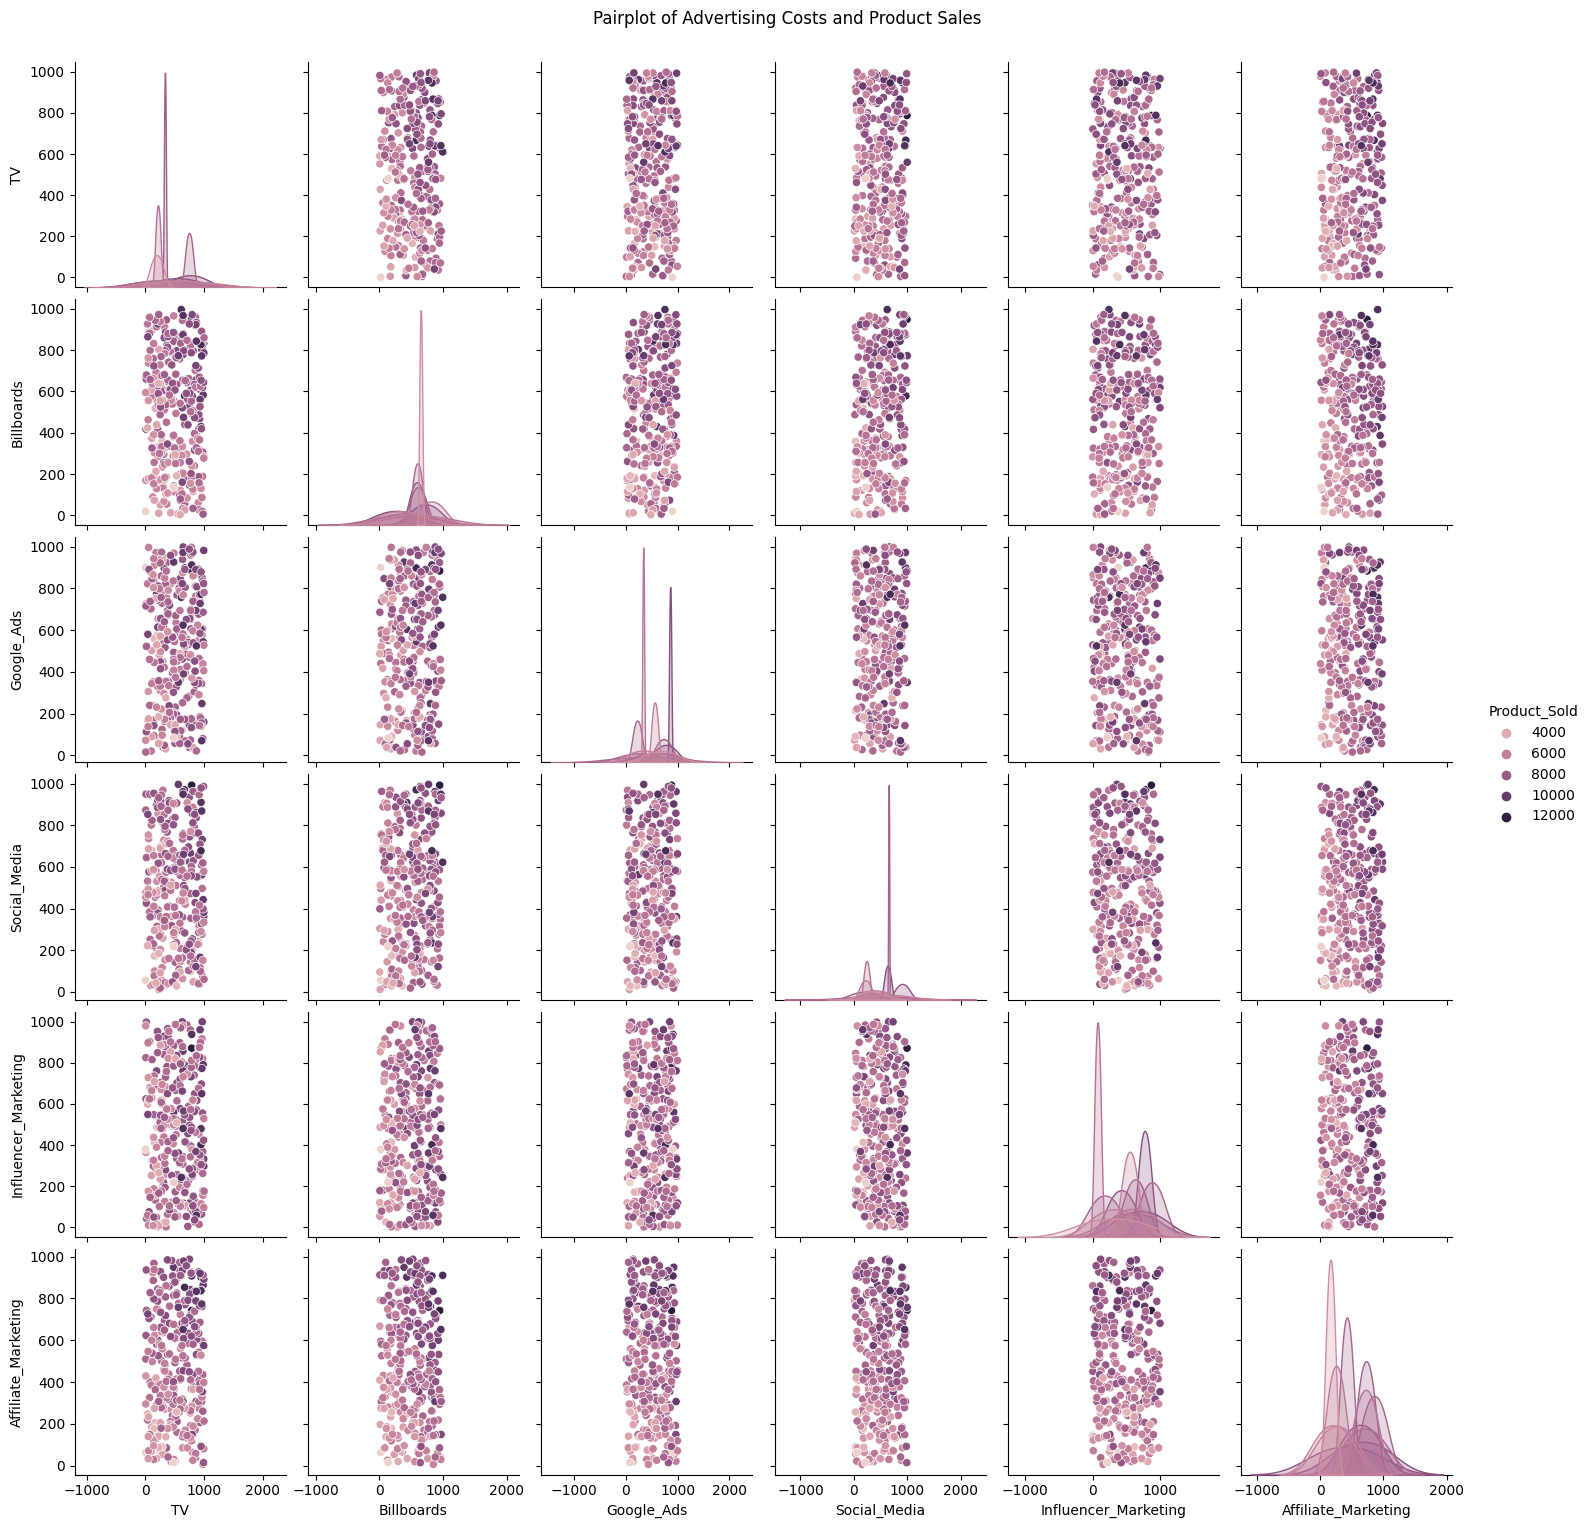

In [8]:
# Pairplot 
sns.pairplot(ad_data, vars=ad_data.columns[:-1], hue='Product_Sold')
plt.suptitle('Pairplot of Advertising Costs and Product Sales', y=1.02)
plt.show()


**Observations**
- Affiliate Marketing and Product_Sold seem to have a visible relationship, suggesting that increasing spending on this channel may have a stronger impact on sales.
- Other advertising channels like Google Ads, TV, and Social Media have wider scatter, implying a less direct correlation to sales.
- No obvious multicollinearity (strong correlation between independent variables) is observed, which is good for regression modeling.

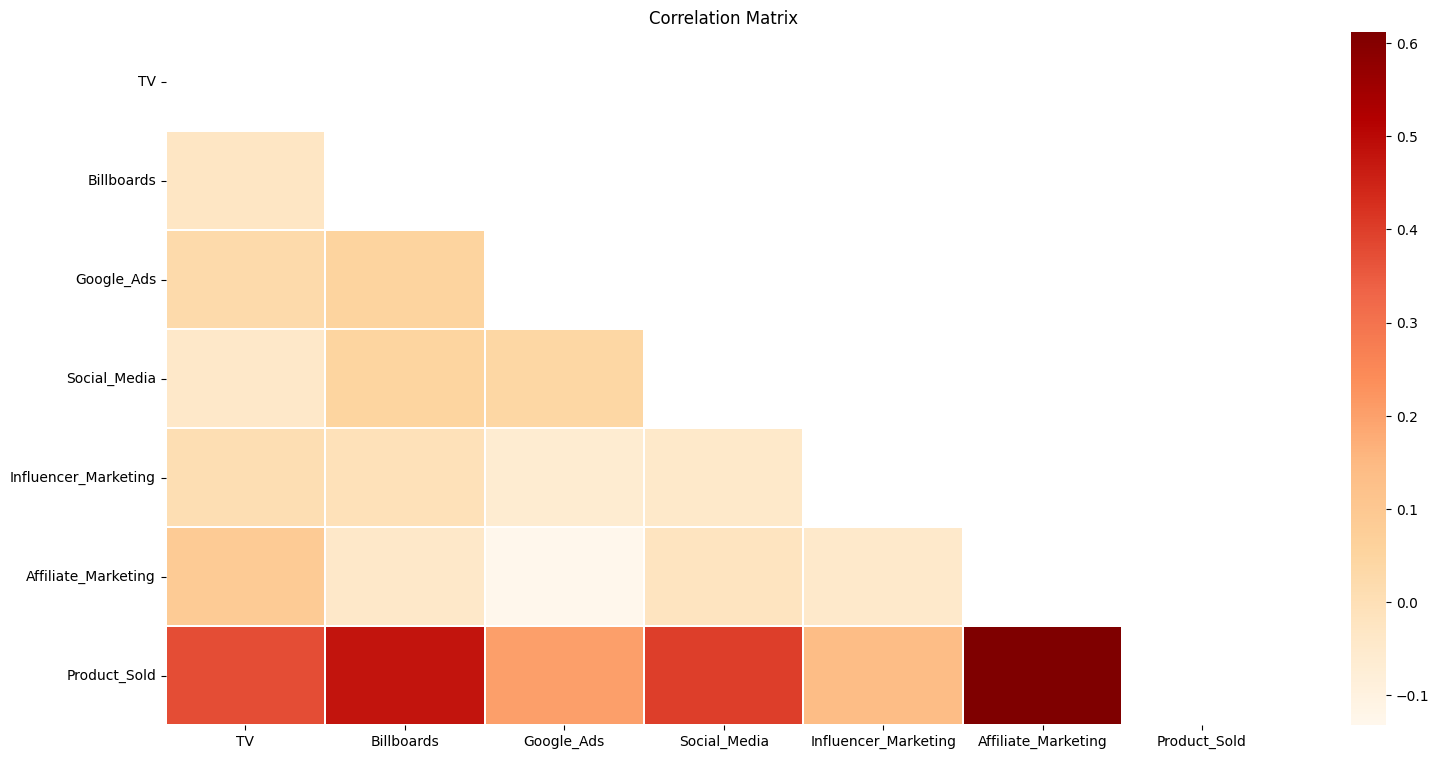

In [9]:
def plot_corr_heatmap(df):
    corr= df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=(18, 9))
    sns.heatmap(corr, cmap="OrRd", annot=True, fmt=".2f", linewidths=.33, annot_kws={"fontsize": "x-small"}, mask=mask)
    plt.title("Correlation Matrix")
    
plot_corr_heatmap(ad_data)

**Key Insights from the Correlation Heatmap**  

1. **Top Impact on Sales:**  
   - **Affiliate Marketing (~0.6-0.7)**: Strongest correlation with sales, making it the most effective channel.  
   - **TV Advertising (~0.37)**: Moderate impact, effective for brand awareness but less direct sales influence.  

2. **Weak/No Correlation:**  
   - **Billboards, Google Ads, Social Media, Influencer Marketing (~0.0-0.2)**: Minimal impact on direct sales, likely better for awareness.  

3. **Low Multicollinearity:**  
   - Advertising platforms don’t heavily overlap, meaning each contributes uniquely.  

### Understanding Outliers

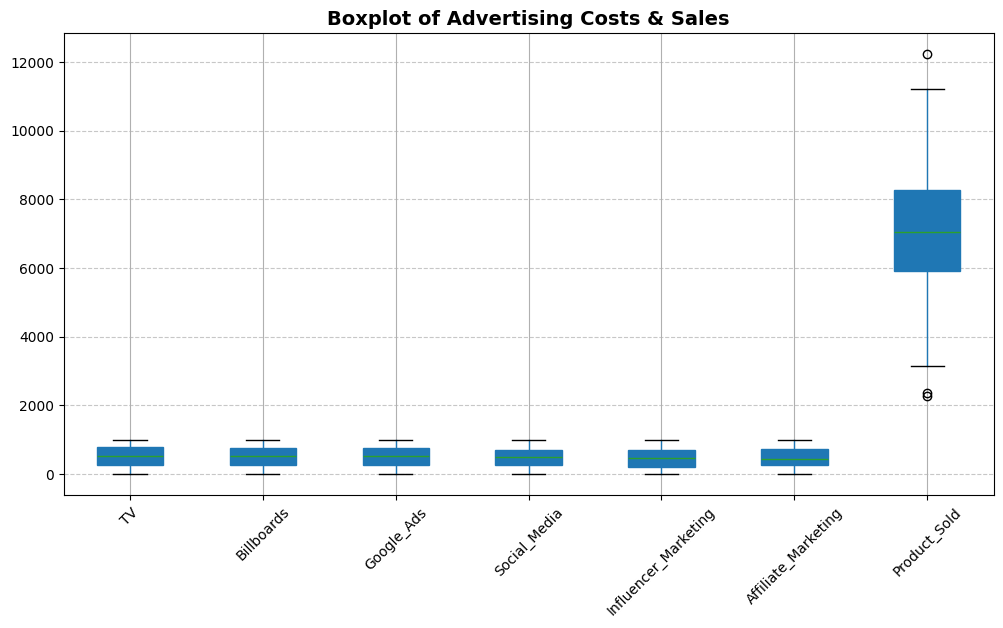

In [10]:
plt.figure(figsize=(12, 6))
box = ad_data.boxplot(patch_artist=True)

colors = ["#FF5733", "#33FF57", "#3357FF", "#F4C724", "#A833FF", "#33FFF0", "#FF33A1"]
for patch, color in zip(box.artists, colors):
    patch.set_facecolor(color)

plt.xticks(rotation=45)
plt.title("Boxplot of Advertising Costs & Sales", fontsize=14, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Key Observations:**
1. **Affiliate Marketing & Product Sold** show a wider spread, indicating variability in spending and sales.
2. **Outliers** are present in sales (`Product_Sold`), which could represent exceptional sales spikes.
3. Other channels have relatively consistent spending patterns.



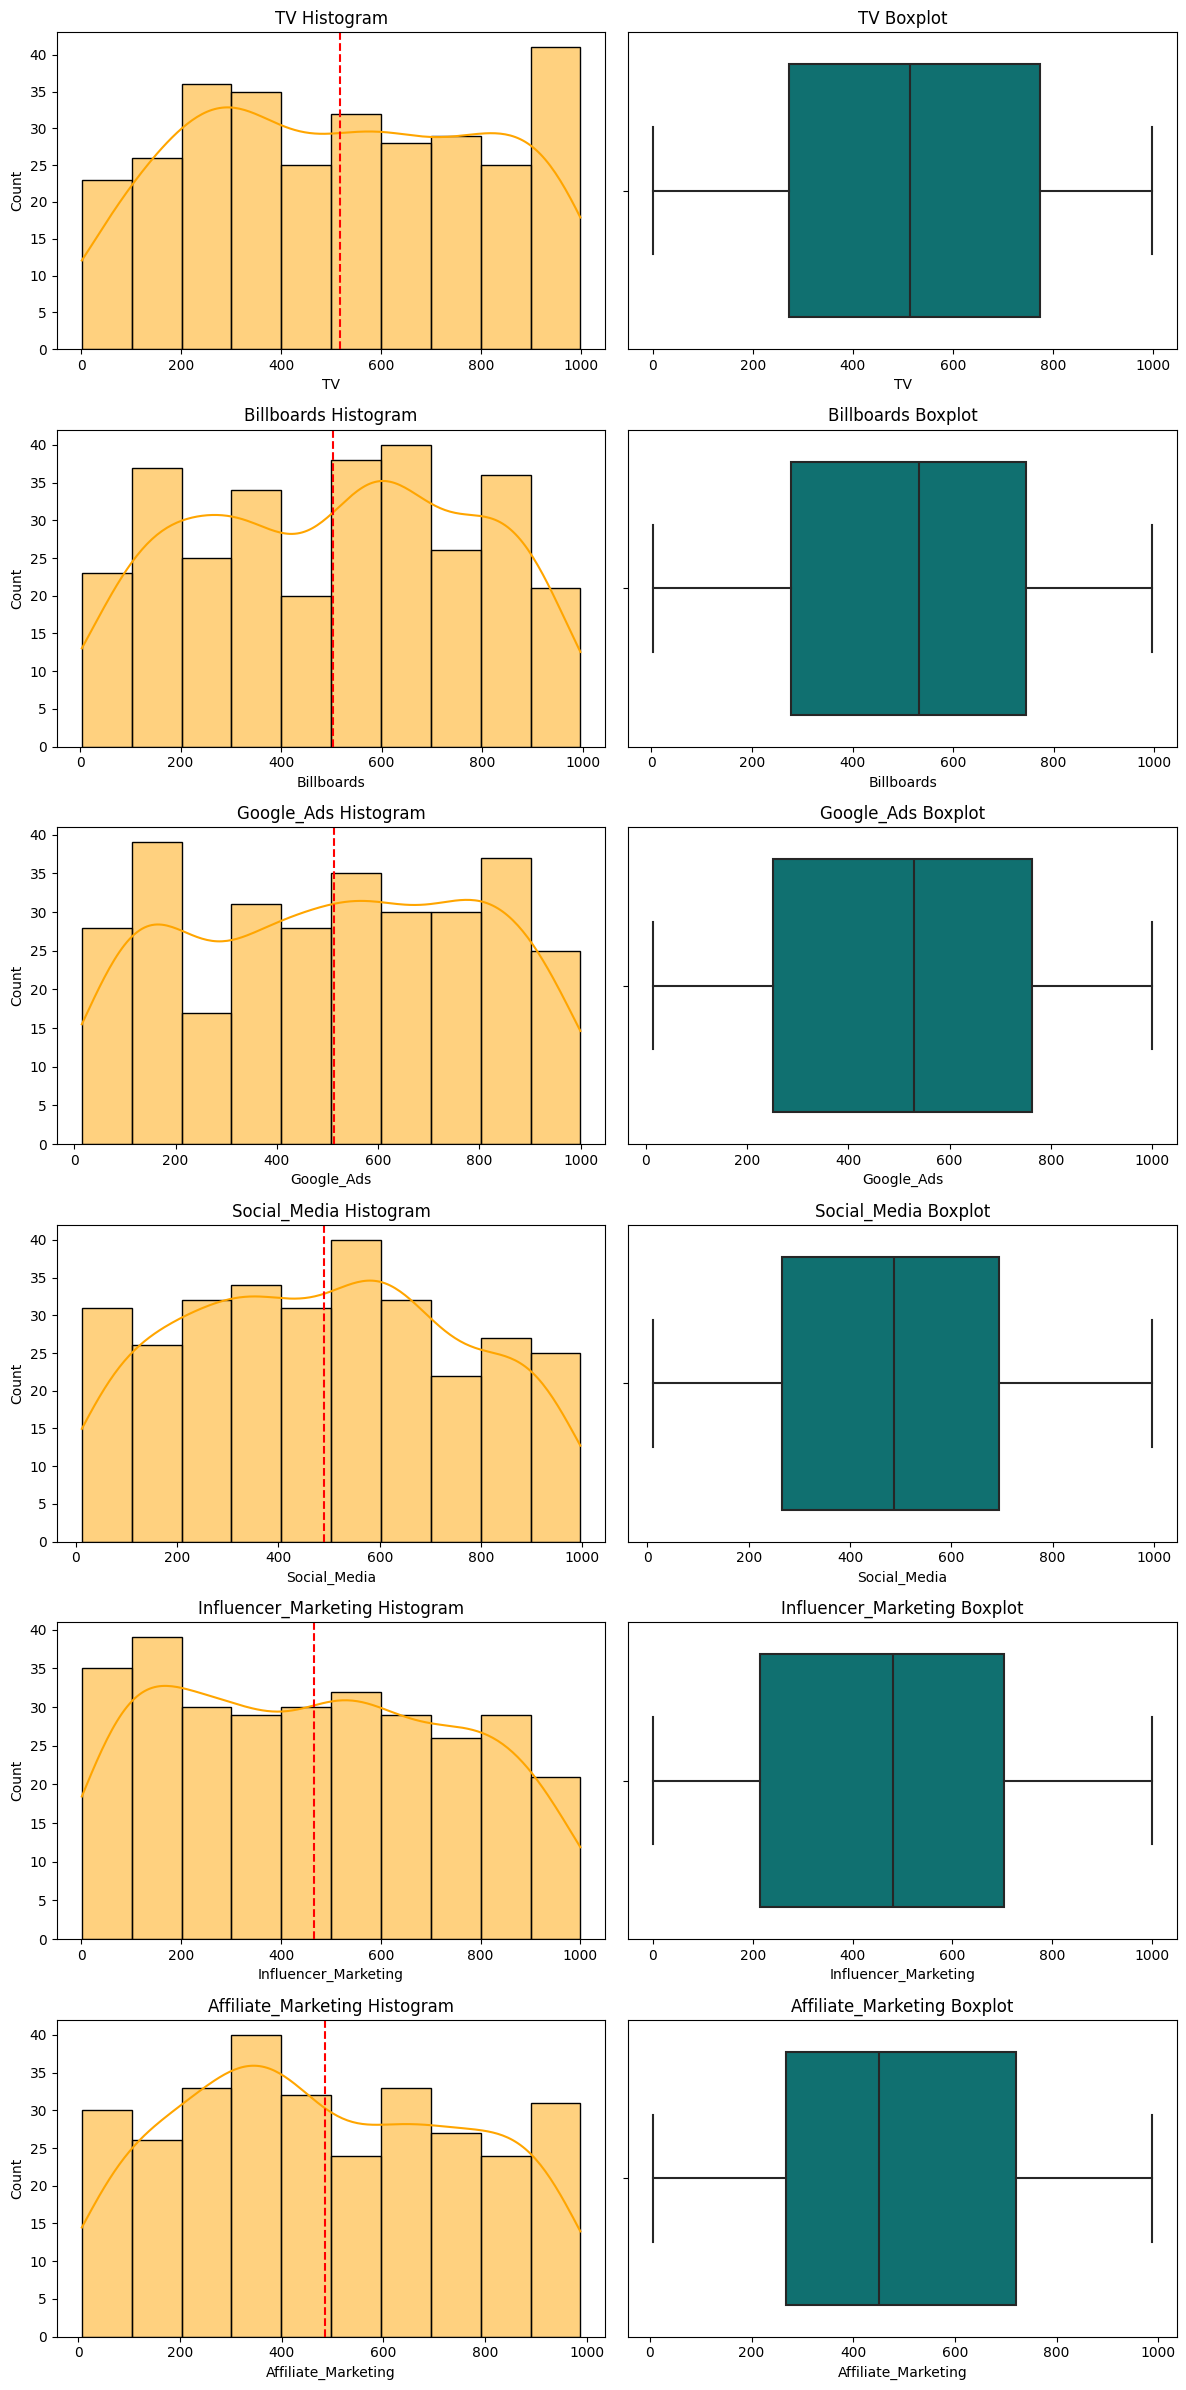

In [11]:
def num_features_plot(df, features, nrows):
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 4 * nrows), layout="tight")

    for idx, feat in enumerate(features):
        sns.histplot(data=df, x=feat, kde=True, ax=axs[idx, 0], color="orange")
        axs[idx, 0].set_title(f"{feat} Histogram")
        axs[idx, 0].axvline(x=df[feat].mean(), color="red", linestyle="--")
        sns.boxplot(data=df, x=feat, ax=axs[idx, 1], color="teal")
        axs[idx, 1].set_title(f"{feat} Boxplot")
    
    plt.show()
    
    
num_features_plot(ad_data, FEATS, len(FEATS))

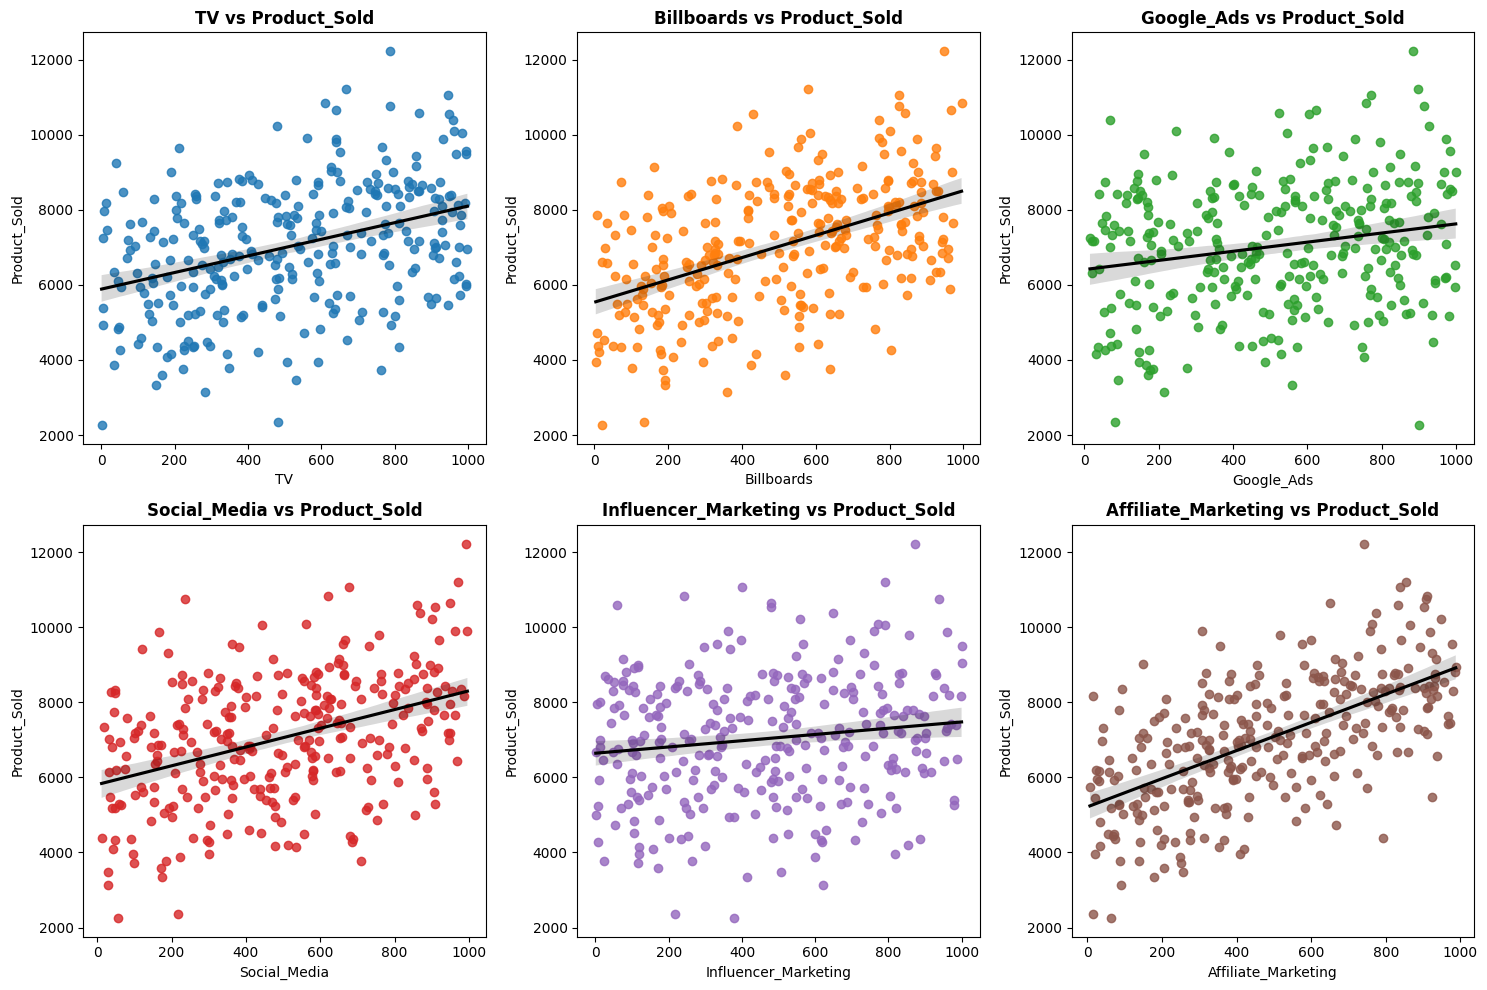

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 6
[LightGBM] [Info] Start training from score 6787.237500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [27]:
# Define a color palette from Seaborn Set2
colors = sns.color_palette()

# Create subplots for scatter plots with regression lines
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
columns = ["TV", "Billboards", "Google_Ads", "Social_Media", "Influencer_Marketing", "Affiliate_Marketing"]

# Generate scatter plots with regression lines
for i, col in enumerate(columns):
    row, col_pos = divmod(i, 3)
    sns.regplot(x=ad_data[col], y=ad_data["Product_Sold"], ax=axes[row, col_pos], 
                scatter_kws={'color': colors[i]}, line_kws={'color': 'black'})
    axes[row, col_pos].set_title(f"{col} vs Product_Sold", fontsize=12, fontweight='bold')

# Improve layout
plt.tight_layout()
plt.show()



### **Key Takeaways:**
1. **Positive Trends:**  
   - **Affiliate Marketing & TV** show the strongest positive correlation with sales.  
   - Other channels like **Billboards, Google Ads, and Social Media** also have slight upward trends.  

2. **Variability:**  
   - **Some scatter patterns are widely spread**, indicating weaker relationships (e.g., Influencer Marketing).  

3. **Regression Line Interpretation:**  
   - The **black regression line** shows the general trend of how sales increase with ad spend.  
   - **Steeper slopes indicate stronger impact** on `Product_Sold`.  

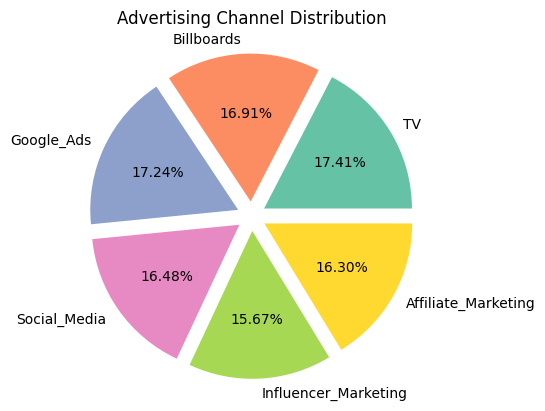

In [13]:
total_costs = ad_data.drop('Product_Sold', axis=1).sum()
plt.pie(total_costs, labels=total_costs.index, autopct='%1.2f%%', colors=sns.color_palette('Set2'),explode=[0.1,0.1,0.1,0.1,0.1,0.1])
plt.title('Advertising Channel Distribution')
plt.show()

**Key Insights from Advertising Channel Distribution**

- TV (17.41%) & Google Ads (17.24%) get the highest budget, indicating priority.
- Billboards (16.91%) & Social Media (16.48%) receive balanced spending across traditional & digital ads.
- Affiliate (16.30%) & Influencer Marketing (15.67%) have the lowest share, suggesting cost-efficiency or lower priority.

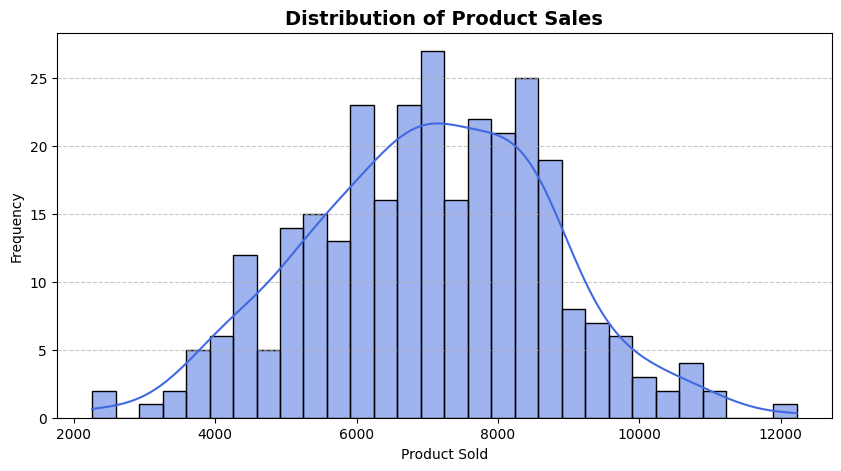

In [14]:
# Distribution of Product Sales
plt.figure(figsize=(10, 5))
sns.histplot(ad_data["Product_Sold"], bins=30, kde=True, color="royalblue")
plt.title("Distribution of Product Sales", fontsize=14, fontweight="bold")
plt.xlabel("Product Sold")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Distribution of Product Sales**  
- The histogram shows **product sales follow a near-normal distribution**, with most values between **6000-9000 units**.  
- **Outliers** exist at both ends, suggesting occasional **low and high sales spikes**.  
- The **KDE curve** suggests a peak around **7500 sales**, indicating a common trend.

**Insight:**  
- The company can **expect average sales around 7000-8000 units** under normal advertising conditions.  
- Strategies should be explored to **reduce volatility** and **increase consistency** in sales.

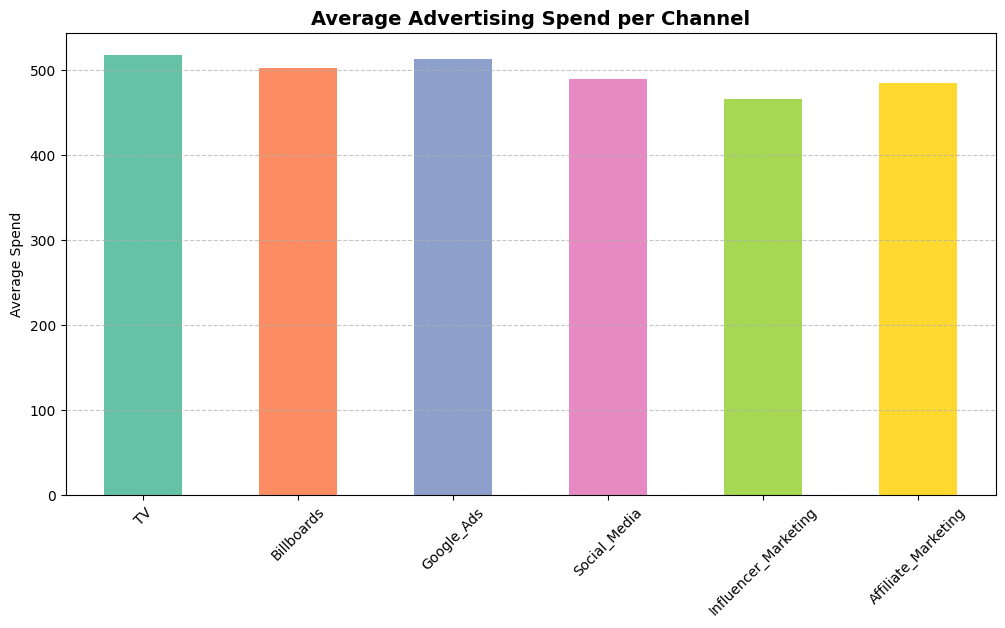

In [15]:
# Advertising Spend per Channel
plt.figure(figsize=(12, 6))
ad_data.drop(columns=["Product_Sold"]).mean().plot(kind="bar", color=sns.color_palette('Set2'))
plt.title("Average Advertising Spend per Channel", fontsize=14, fontweight="bold")
plt.ylabel("Average Spend")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Advertising Spend per Channel**
- **TV, Google Ads, and Billboards** have slightly **higher average spend** than other platforms.  
- **Influencer Marketing & Social Media have lower spending**, which might indicate a preference for traditional media.  
- Spending is fairly balanced across channels, but **some platforms might be underutilized**.

**Insight:**  
- If **Affiliate Marketing is driving higher sales (based on correlation),** increasing its budget **could boost returns**.  
- **Reallocating funds from low-impact channels** (if identified) can improve efficiency.

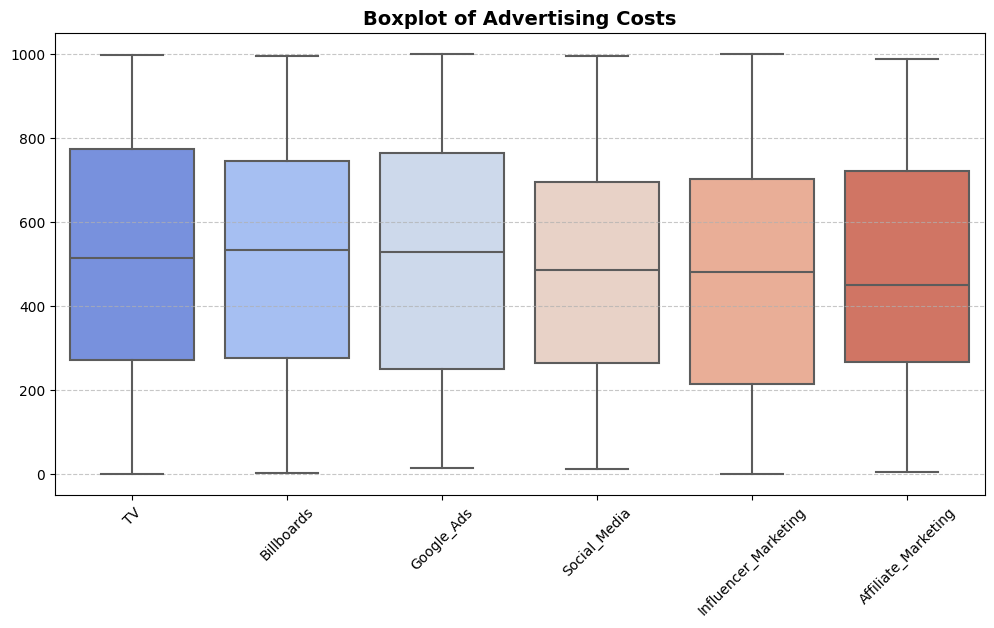

In [16]:
# Boxplot for Outlier Detection in Ad Spend
plt.figure(figsize=(12, 6))
sns.boxplot(data=ad_data.drop(columns=["Product_Sold"]), palette="coolwarm")
plt.title("Boxplot of Advertising Costs", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Boxplot of Advertising Costs**  
- Spending is **evenly spread** across all advertising channels, but some **high-value outliers** exist.  
- **A few extreme values** in different platforms might represent **expensive campaigns** that need analysis.  
- The spread of data shows **some channels have a wider variance** in spending than others.

## Feature Importance

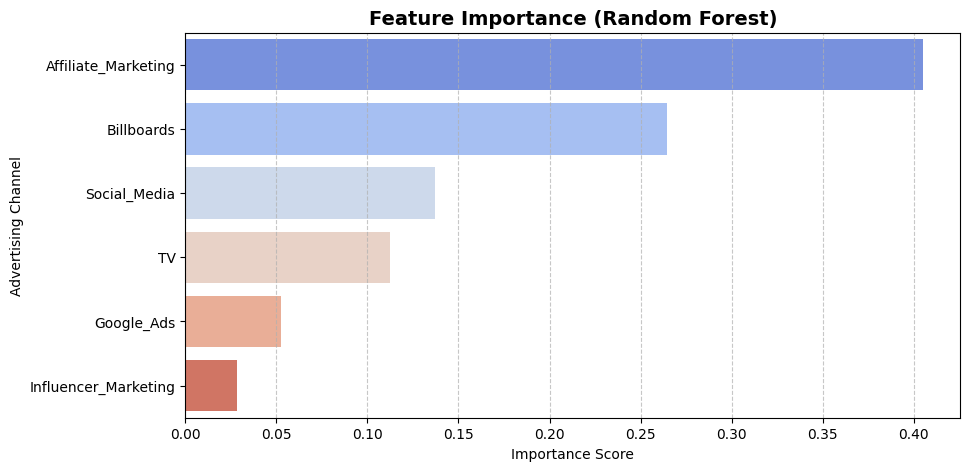

In [17]:
X = ad_data.drop(columns=["Product_Sold"])  # Features (advertising spend)
y = ad_data["Product_Sold"]  # Target (units sold)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importance = rf_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")
plt.title("Feature Importance (Random Forest)", fontsize=14, fontweight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Advertising Channel")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

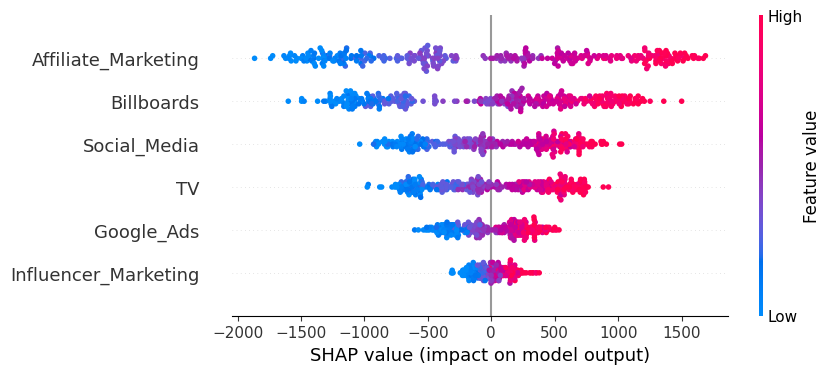

In [18]:
X = ad_data.drop(columns=["Product_Sold"])  # Features (advertising spend)
y = ad_data["Product_Sold"]  # Target (units sold)

# Train an XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

# Plot SHAP summary plot
shap.plots.beeswarm(shap_values)

**Insights from Feature Importance & SHAP Analysis**

**Feature Importance (Random Forest)**
- **Affiliate Marketing** is the most influential factor, driving the highest impact on sales.
- **Billboards and Social Media** also have significant effects, meaning traditional and digital advertising both play key roles.
- **TV and Google Ads** contribute moderately to sales but are not the primary drivers.
- **Influencer Marketing** has the least impact, suggesting it may not be an effective use of the budget.

**SHAP Beeswarm Plot**
- **Higher values of Affiliate Marketing spending strongly increase sales**, confirming its importance.
- **Billboards and Social Media have mixed effects**, where spending more does not always guarantee higher sales.
- **TV Ads and Google Ads show diminishing returns**, indicating that past a certain point, increasing spend does not significantly boost sales.
- **Influencer Marketing has mostly negative or low impact**, meaning increasing its budget may not lead to better results.

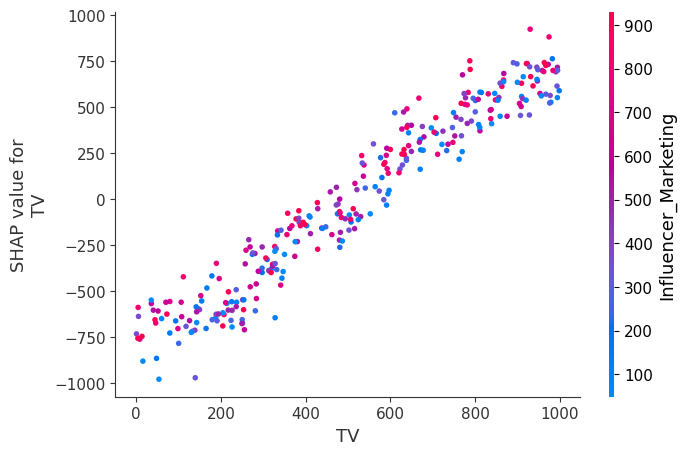

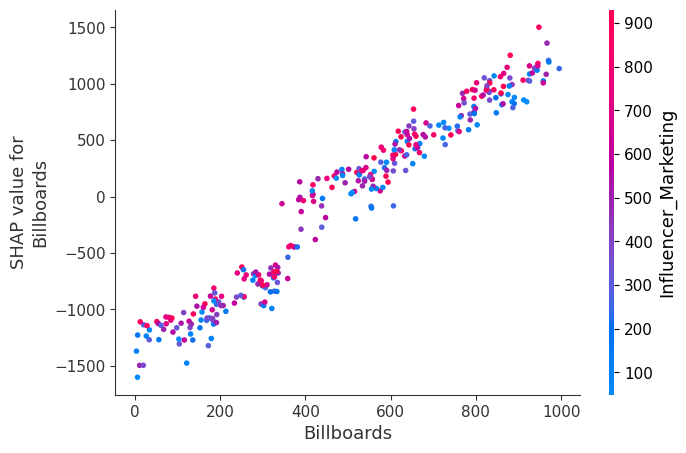

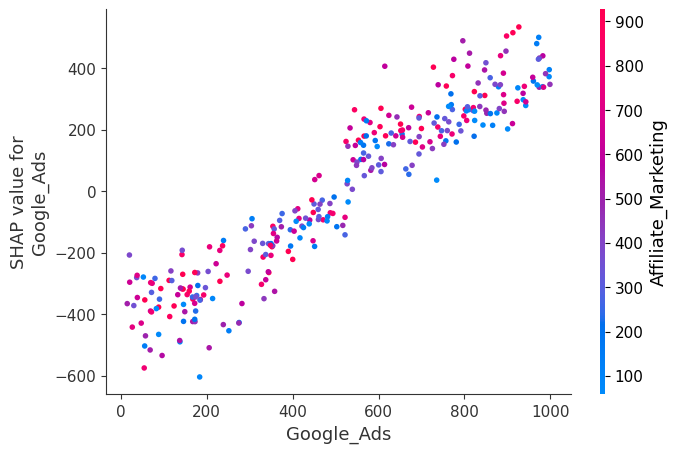

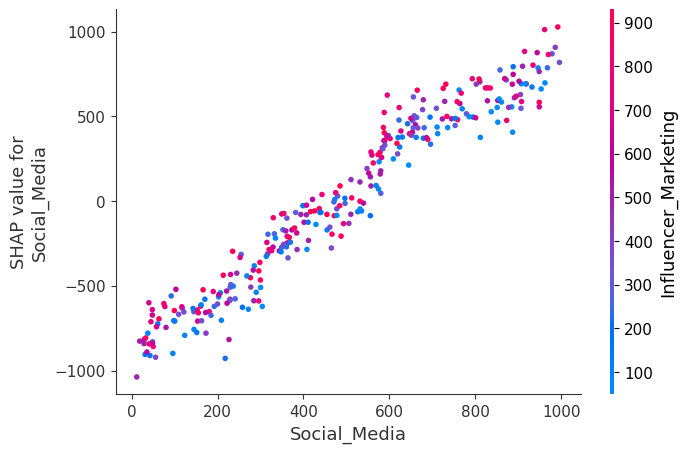

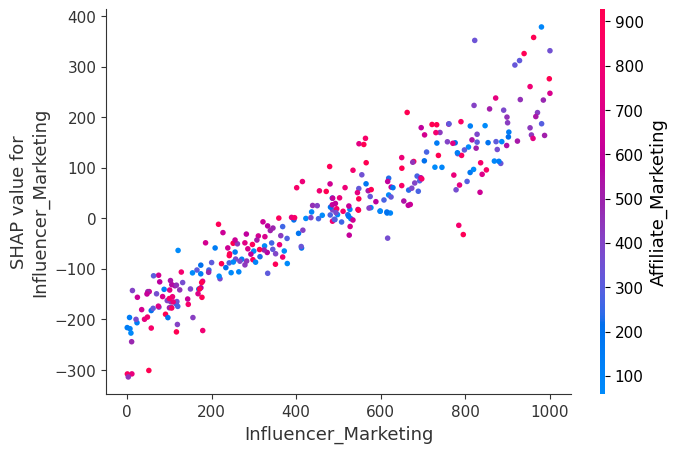

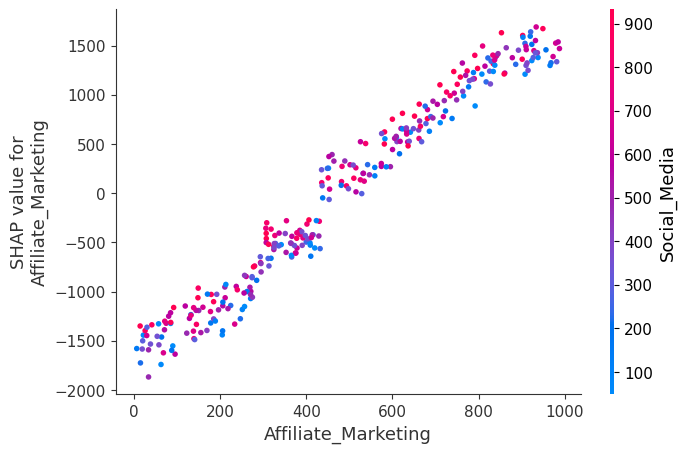

In [19]:
for feature in FEATS:
    shap.dependence_plot(feature, shap_values.values, X)


## Market Mix Modeling (MMM)

In [20]:
# Add a constant for the intercept in regression model
X_mmm = sm.add_constant(X)

# Fit a Multiple Linear Regression model
mmm_model = sm.OLS(y, X_mmm).fit()

# Display model summary
mmm_summary = mmm_model.summary()
mmm_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Product_Sold   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.347e+06
Date:                Mon, 10 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:50:35   Log-Likelihood:                -1123.6
No. Observations:                 300   AIC:                             2261.
Df Residuals:                     293   BIC:                             2287.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0887      2.723      0.033      0.974      -5.270       5.447
TV                       2.0011      0.002    956.708      0.000       1.997       2.005
Billboards               2.9980      0.002   1375.489      0.000       2.994       3.002
Google_Ads               1.4997      0.002    704.836      0.000       1.496       1.504
Social_Media             2.5000      0.002   1138.719      0.000       2.496       2.504
Influencer_Marketing     1.1998      0.002    574.871      0.000       1.196       1.204
Affiliate_Marketing      3.9989      0.002   1827.081      0.000       3.995       4.003
==============================================================================
Omnibus:                        0.258   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.170
Skew:                           0.057   Prob(JB):                        0.918
Kurtosis:                       3.028   Cond. No.                     5.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Market Mix Modeling (MMM) Insights**
    
- The Multiple Linear Regression Model estimates how each advertising channel contributes to Product Sold:

**Key Results:**  

- Affiliate Marketing (coef: ~3.99) → Highest impact on sales.
- Billboards (coef: ~2.99) → Significant effect on product sales.
- Social Media (coef: ~2.50) → Contributes well to sales.
- TV (coef: ~2.00) → Moderate impact on sales.
- Google Ads (coef: ~1.50) → Lower impact than expected.
- Influencer Marketing (coef: ~1.20) → Least effective channel.

## Predict Future Sales 

**Models:**
- Linear Regression
- Ridge Regression
- Random Forest
- Gradient Boosting
- Support Vector Regressor
- XGBoost
- LightGBM
- CatBoost

In [21]:

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

param_grids = {
    "Ridge Regression": {"alpha": [0.1, 1.0, 10.0]},
    "Random Forest": {"n_estimators": [50, 100], "max_depth": [None, 10]},
    "Gradient Boosting": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    "Support Vector Regressor": {"C": [0.1, 1, 10], "epsilon": [0.01, 0.1, 1]},
    "XGBoost": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    "LightGBM": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    "CatBoost": {"iterations": [50, 100], "learning_rate": [0.01, 0.1]}
}

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models and perform hyperparameter tuning where applicable
results = []
for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring="r2", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = best_model.predict(X_test)

    # Evaluate model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({
        "Model": name,
        "Best Params": grid_search.best_params_ if name in param_grids else "Default",
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
results_df

/Users/jeeva/anaconda3/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/jeeva/anaconda3/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/jeeva/anaconda3/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 240, number of used features: 6
[LightGBM] [Info] Start training from score 6960.037500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,Model,Best Params,MAE,MSE,RMSE,R2 Score
0,Linear Regression,Default,7.085374,7.536592e+01,8.681355,0.999974
1,Ridge Regression,{'alpha': 10.0},7.085554,7.537023e+01,8.681603,0.999974
2,Random Forest,"{'max_depth': None, 'n_estimators': 50}",500.784333,4.199031e+05,647.999283,0.853394
3,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",362.596702,2.351913e+05,484.965222,0.917885
4,Support Vector Regressor,"{'C': 10, 'epsilon': 0.01}",1315.586601,2.642330e+06,1625.524582,0.077452
5,XGBoost,"{'learning_rate': 0.1, 'n_estimators': 100}",561.516321,4.752895e+05,689.412414,0.834057
6,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100}",353.088531,2.133049e+05,461.849407,0.925526
7,CatBoost,"{'iterations': 100, 'learning_rate': 0.1}",291.855208,1.583295e+05,397.906363,0.944721
